In [3]:
!pip3.10 install plotly --break-system-packages

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


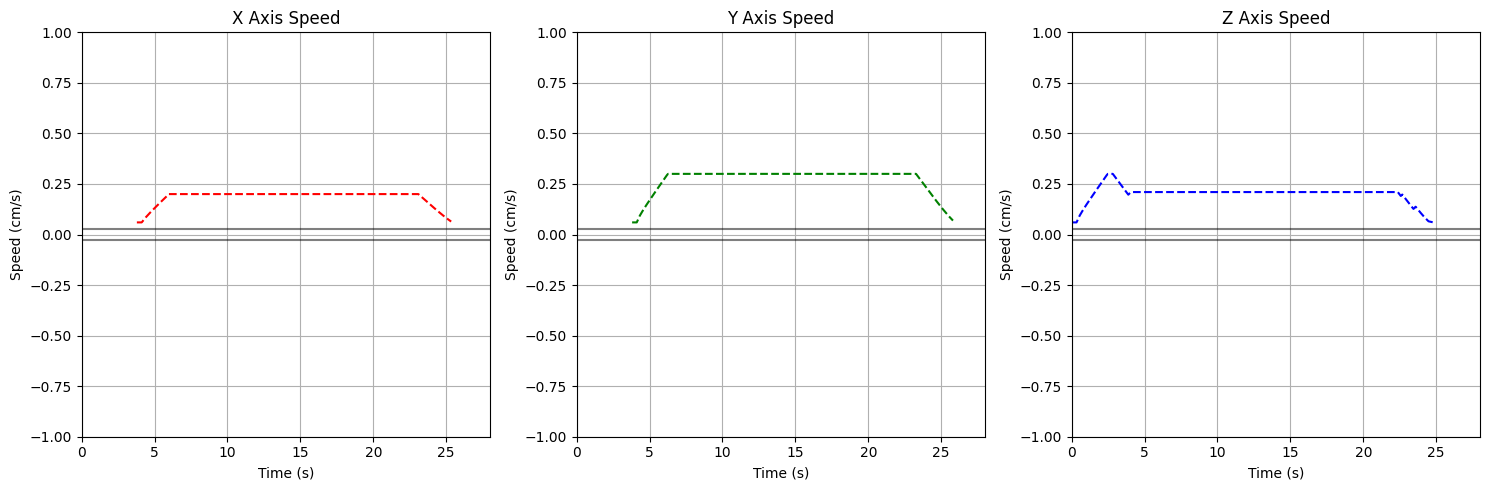

In [134]:
# Example of input.txt:
"""
X10
8813996
30.00
Y10
8834836
30.00
Z10
8855728
30.00
X10
8876644
30.00
Y10
8897488
30.00
Z10
8918372
30.00
X11
8939292
30.00
Y11
8960144
30.00
Z11
8981020
30.00
X11
9001940
30.00
"""

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

string = [l.strip('\n') for l in open('input.txt', 'r').readlines()]

# Parse coordinates, times and calculate speeds
coords = {}
current_coord = None
x_points, y_points, z_points = [], [], []
x_times, y_times, z_times = [], [], []
x_speeds, y_speeds, z_speeds = [], [], []
x_speeds2, y_speeds2, z_speeds2 = [], [], []
colors = []  # Store colors based on vacuum state
step_to_cm = 1/50

# Initialize first values 
x, y, z = 0, 0, 0
skipping = False

for i, line in enumerate(string):
    if line[:2] == "--":
        skipping = not skipping
        continue
    if skipping:
        continue
    if line[0] in ['X', 'Y', 'Z']:
        current_coord = line[0]
        direction = int(line[1])  # First digit is direction
        vacuum_state = int(line[2])  # Second digit is vacuum state
        colors.append('red' if vacuum_state == 1 else 'blue')
    elif line[0].isdigit() and "." not in line:
        line = int(line) / 1000000   # Convert microseconds to seconds
        if line != 0:
            time = line
        # Convert steps to cm and handle direction
        if current_coord == 'X':
            x += (1 if direction == 1 else -1) * step_to_cm
            y += (1 if direction == 1 else -1) * step_to_cm
            z += (-1 if direction == 1 else 1) * step_to_cm
            x_points.append(x)
            y_points.append(y)
            z_points.append(z)
            x_times.append(time)
            if len(x_times) > 1:
                dt = x_times[-1] - x_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                x_speeds.append((1 if direction == 1 else -1) * speed)

        elif current_coord == 'Y':
            y += (1 if direction == 1 else -1) * step_to_cm
            x -= (1 if direction == 1 else -1) * step_to_cm
            y_points.append(y)
            x_points.append(x)
            z_points.append(z)
            y_times.append(time)
            if len(y_times) > 1:
                dt = y_times[-1] - y_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                y_speeds.append((1 if direction == 1 else -1) * speed)

        elif current_coord == 'Z':
            z += (1 if direction == 1 else -1) * step_to_cm
            z_points.append(z)
            x_points.append(x)
            y_points.append(y)
            z_times.append(time)
            if len(z_times) > 1:
                dt = z_times[-1] - z_times[-2]
                speed = step_to_cm / dt if dt > 0 else 0
                z_speeds.append((1 if direction == 1 else -1) * speed)

    elif line[0].isdigit() or line[1].isdigit() and "." in line:
        line = float(line)
        # Convert steps/s to cm/s
        speed_cm = line * step_to_cm
        if current_coord == 'Z':
            z_speeds2.append(speed_cm)
        elif current_coord == 'Y':
            y_speeds2.append(speed_cm)
        elif current_coord == 'X':
            x_speeds2.append(speed_cm)

# Create interactive 3D plot using plotly
fig_3d = go.Figure(data=[go.Scatter3d(
    x=x_points,
    y=y_points,
    z=z_points,
    mode='lines+markers',
    marker=dict(
        size=2,
        color=colors,  # Use colors list for coloring points
    ),
    line=dict(
        width=2,
        color=colors  # Use same colors for lines
    )
)])

fig_3d.update_layout(
    title='3D Trajectory',
    scene=dict(
        xaxis_title='X Position (cm)',
        yaxis_title='Y Position (cm)',
        zaxis_title='Z Position (cm)',
        aspectmode='cube'  # Force equal aspect ratio
    ),
    width=1000,  # Increase width to better show 3D plot
    height=1000, # Increase height to match width
    showlegend=False
)

fig_3d.show()

x_high = 28
y_low = -1
y_high = 1

# Create speed plots
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(x_times, x_speeds2, 'r--', label='X Speed 2')
plt.axhline(y=3/110.65, color='k', linestyle='-', alpha=0.5)
plt.axhline(y=-3/110.65, color='k', linestyle='-', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('X Axis Speed')
plt.ylim(y_low, y_high)
plt.xlim(0, x_high)
plt.grid(True)

plt.subplot(132)
plt.plot(y_times, y_speeds2, 'g--', label='Y Speed 2')
plt.axhline(y=3/110.65, color='k', linestyle='-', alpha=0.5)
plt.axhline(y=-3/110.65, color='k', linestyle='-', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Y Axis Speed')
plt.ylim(y_low, y_high)
plt.xlim(0, x_high)
plt.grid(True)

plt.subplot(133)
plt.plot(z_times, z_speeds2, 'b--', label='Z Speed 2')
plt.axhline(y=3/110.65, color='k', linestyle='-', alpha=0.5)
plt.axhline(y=-3/110.65, color='k', linestyle='-', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Z Axis Speed')
plt.ylim(y_low, y_high)
plt.xlim(0, x_high)
plt.grid(True)

plt.tight_layout()
plt.show()


In [130]:
len(z_times), len(z_speeds), len(z_speeds2)



(3, 2, 3)